In [1]:
import numpy as np
from matplotlib import pyplot as plt
import netCDF4 as nc
import ipywidgets as widgets

In [121]:
def cov(s_i, s_j, var_p=1.0, l=1.0, norm=2):
    '''
    Squarred exponential function.

    Parameters
    ----------
    s_i: array_like
        First point.
    s_j: array_like
        Second point.
    var_p: float
        Prior varince.
    l: float
        Length scale.

    Returns
    -------
    float
        The covariance of the two points.
    '''
    return var_p * np.exp( - 1 / ( 2 * l **2 ) * np.linalg.norm(s_i - s_j, norm)**2 )

def phi(s, S, K_i_inv, var_p=1.0, l=1.0):
    '''
    Computes the :math:´\phi´ according to the position :math:´s´.

    Parameters
    ----------
    s: array_like
        The position to interpolate.
    S: array_like
        The known sampled positions.
    K_i_inv: array_like
        The i-th row of the inverse system matrix.
    var_p: float
        Prior varince.
    l: float
        The influence of the distance on the interpolation.

    Returns
    -------
    float
        The :math:´phi´ of the i-th row solving the system of equations.
    '''
    K_i = np.array([cov(s_i, s, var_p, l) for s_i in S])
    phi_i = K_i_inv * K_i
    return np.sum(phi_i)

def kriging(S, f, var, s_interpolated, var_p, l):
    '''
    Computes a multivatiate random field using kriging based on the observed points `S` and values `f`.

    Parameters
    ----------
    S: array_like
        Sampled points positions.
    f: array_like
        Values observed at the sampled points.
    var: array_like
        The (estimated) variance of the observed values.
    s_interpolated: array_like
        Points to interpolate the new values.
    var_p: float
        Prior varince.
    l: float
        The influence of the distance on the interpolation.

    Returns
    -------
    mu_interpolated: array_like
        The interpolated mean values.
    var_interplated: array_like
        The interpolated variance.
    '''
    K = np.array([
    [cov(S[i], S[j], var_p, l) for j in range(len(f))]
        for i in range(len(f))])
    K += np.diagflat(var)

    K_inv = np.linalg.inv(K)

    mu_interpolated = np.array([
        [phi(s, S, K_inv[i,:], var_p, l) for i in range(len(f))]
    for s in s_interpolated]) @ f

    var_sum = np.array([
        [phi(s, S, K_inv[i,:], var_p, l) * cov(S[i], s, var_p, l) for i in range(len(f))]
    for s in s_interpolated])

    var_interpolated = np.array([cov(s, s, var_p, l) for s in s_interpolated]) - np.sum(var_sum, axis=1)

    return mu_interpolated, var_interpolated

def piecewise_kriging(mean, variance, var_p, l, scale, confidence=3):
    x = np.arange(mean.shape[0])
    y = np.arange(mean.shape[1])

    S = np.transpose(np.meshgrid(x, y), [1,2,0])

    f = mean
    var_i = variance

    influence_width = int(np.ceil(confidence * l)) 
    new_shape = (np.array(mean.shape, dtype=np.int64) - 1 ) * scale

    mu = np.zeros(new_shape)
    var = np.zeros(new_shape)
    for i in range(mean.shape[0]):
        for j in range(mean.shape[1]):
            left = max(0, j - influence_width)
            right = min(mean.shape[1], j + influence_width + 1)

            bottom = max(0, i - influence_width)
            top = min(mean.shape[0], i + influence_width + 1)

            f_cell = f[bottom:top+1, left:right+1]
            var_i_cell = var_i[bottom:top+1, left:right+1].flatten()

            v_left = f_cell.shape[1] // 2 - 1
            v_right = f_cell.shape[1] // 2
            if j + influence_width + 1 > mean.shape[1]:
                v_left += j + influence_width + 1 - mean.shape[1]
                v_right += j + influence_width + 1 - mean.shape[1]

            u_bottom = f_cell.shape[0] // 2 - 1
            u_top = f_cell.shape[0] // 2
            if i + influence_width +1 > mean.shape[0]:
                u_bottom += i + influence_width + 1 - mean.shape[0]
                u_top += i + influence_width + 1 - mean.shape[0]

            window_shape = f_cell.shape
            interploation_shape = (np.array(window_shape) - 1) * scale + 1
            f_cell = f_cell.flatten()

            S_cell = S[bottom:top+1, left:right+1].reshape((-1,2))

            s_x = np.linspace(S_cell[:,0].min(), S_cell[:,0].max(), interploation_shape[1])
            s_y = np.linspace(S_cell[:,1].min(), S_cell[:,1].max(), interploation_shape[0])

            s_interpolated = np.transpose(np.meshgrid(s_x, s_y), [1,2,0]).reshape((-1,2))

            mu_area, var_area = kriging(S_cell, f_cell, var_i_cell, s_interpolated, var_p, l)
            mu_area = mu_area.reshape(interploation_shape)
            var_area = var_area.reshape(interploation_shape)

            if j == mean.shape[1] - 1:
                v_right += 1
            if i == mean.shape[0] - 1:
                u_top += 1
            mu_cell = mu_area[scale * u_bottom:scale * u_top, scale * v_left:scale * v_right]
            var_cell = var_area[scale * u_bottom:scale * u_top, scale * v_left:scale * v_right]

            selector_y_end = (i+1)*scale if i < mean.shape[0] - 1 else (i+1)*scale + 1
            selector_x_end = (j+1)*scale if j < mean.shape[1] - 1 else (j+1)*scale + 1

            mu[i*scale:selector_y_end, j*scale:selector_x_end] = mu_cell
            var[i*scale:selector_y_end, j*scale:selector_x_end] = var_cell

    return mu, var

In [3]:
ds = nc.Dataset('../../../Data/weather/netcdf/day20_200_temp.nc')
print(ds)
print(ds['cnrm'])

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    Conventions: CF-1.0
    history: 2009-05-20 11:30:32 GMT by mars2netcdf-0.92
    dimensions(sizes): longitude(144), latitude(73), number(9), time(1)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 number(number), int32 time(time), int16 cnrm(time, number, latitude, longitude), int16 crfc(time, number, latitude, longitude), int16 lody(time, number, latitude, longitude), int16 scnr(time, number, latitude, longitude), int16 scwf(time, number, latitude, longitude), int16 smpi(time, number, latitude, longitude), int16 ukmo(time, number, latitude, longitude)
    groups: 
<class 'netCDF4._netCDF4.Variable'>
int16 cnrm(time, number, latitude, longitude)
    scale_factor: 0.00048481605286229435
    add_offset: 215.2862736067987
    _FillValue: -32767
    missing_value: -32767
    units: K
    long_name: Temperature
unlimited dimensions: time
current sha

In [4]:
@widgets.interact(idx=widgets.Play(min=0,max=8, step=1, interval=500))
def inspect(idx=0):
    plt.figure(figsize=(18,6))
    plt.title(str(idx))
    plt.imshow(ds['cnrm'][0,idx,:], origin='lower')
    plt.colorbar()
    plt.show()

interactive(children=(Play(value=0, description='idx', interval=500, max=8), Output()), _dom_classes=('widget-…

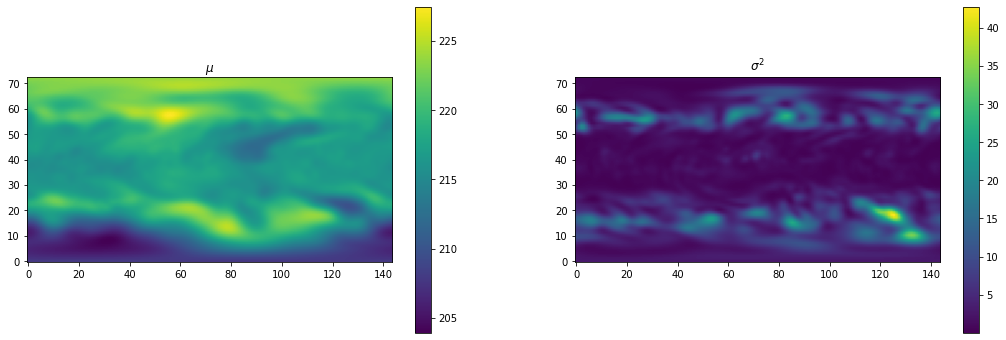

In [103]:
samples = ds['cnrm'][0]

mean = np.mean(samples, axis=0)
var = np.var(samples, axis=0)

plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.title(r'$\mu$')
plt.imshow(mean, origin='lower')
plt.colorbar()

plt.subplot(1,2,2)
plt.title(r'$\sigma^2$')
plt.imshow(var, origin='lower')
plt.colorbar()

plt.show()

# Single cell

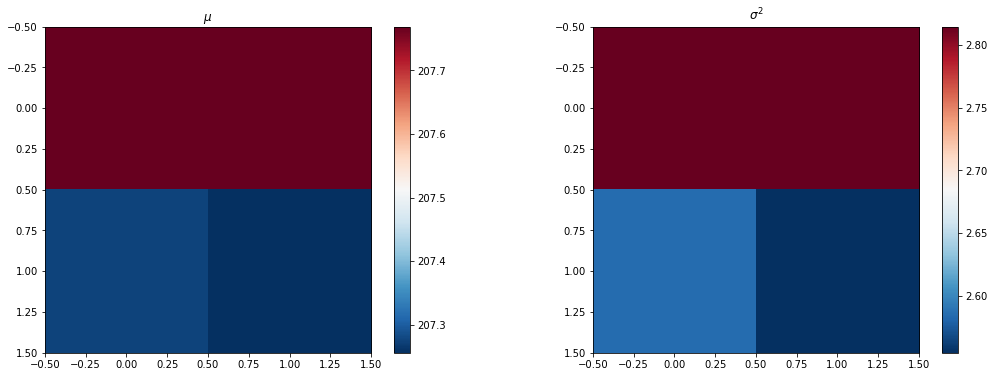

[[207.7688775  207.7688775 ]
 [207.2756041  207.25599598]]


In [126]:
mean_subset = mean[:2,:2]
var_subset = var[:2,:2]

plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.title(r'$\mu$')
plt.imshow(mean_subset, cmap='RdBu_r')
plt.colorbar()

plt.subplot(1,2,2)
plt.title(r'$\sigma^2$')
plt.imshow(var_subset, cmap='RdBu_r')
plt.colorbar()

plt.show()

print(mean_subset)

In [127]:
x = np.linspace(0, 1, 2)
y = np.linspace(0, 1, 2)

S = np.transpose(np.meshgrid(x, y), [1,2,0]).reshape((-1,2))

f = mean_subset.flatten()
var_i = var_subset.flatten()

l = 0.2

scale = 8

s_x = np.linspace(0, 1, len(x) * scale)
s_y = np.linspace(0, 1, len(y) * scale)
new_shape = np.array([len(s_x), len(s_y)])

s_interpolated = np.transpose(np.meshgrid(s_x, s_y), [1,2,0]).reshape((-1,2))

mu_cell, var_cell = kriging(S, f, np.ones_like(var_i), s_interpolated, var_i.max(), l)

mu_cell = mu_cell.reshape((len(s_x), len(s_y)))
var_cell = var_cell.reshape((len(s_x), len(s_y)))

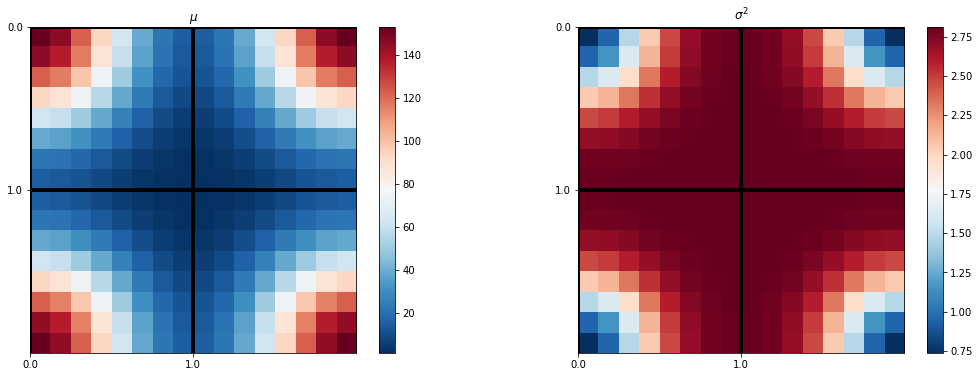

In [128]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.title(r'$\mu$')
plt.imshow(mu_cell, cmap='RdBu_r')
plt.xticks(np.arange(0,new_shape[0],scale)-0.5, x)
plt.yticks(np.arange(0,new_shape[1],scale)-0.5, y)
plt.grid(c='k', lw=4)
plt.colorbar()

plt.subplot(1,2,2)
plt.title(r'$\sigma^2$')
plt.imshow(var_cell, cmap='RdBu_r')
plt.xticks(np.arange(0,new_shape[0],scale)-0.5, x)
plt.yticks(np.arange(0,new_shape[1],scale)-0.5, y)
plt.grid(c='k', lw=4)
plt.colorbar()

plt.show()

# Sample subset

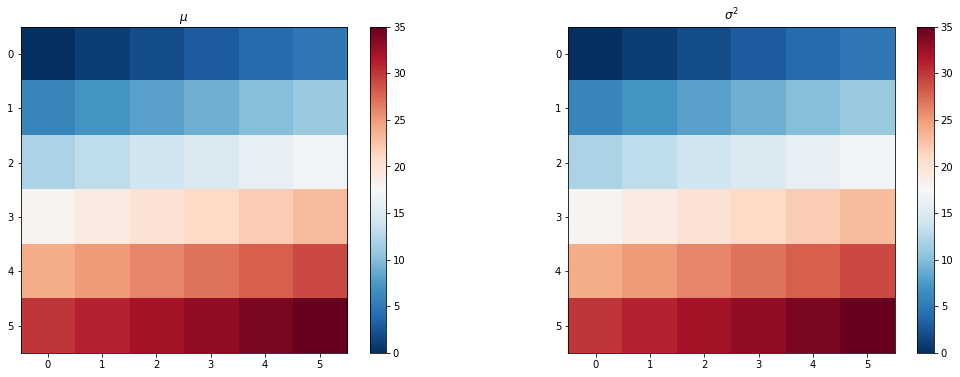

In [213]:
mean_subset = np.arange(6*6).reshape((6,6))
var_subset = np.arange(6*6).reshape((6,6))

plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.title(r'$\mu$')
plt.imshow(mean_subset, cmap='RdBu_r')
plt.colorbar()

plt.subplot(1,2,2)
plt.title(r'$\sigma^2$')
plt.imshow(var_subset, cmap='RdBu_r')
plt.colorbar()

plt.show()

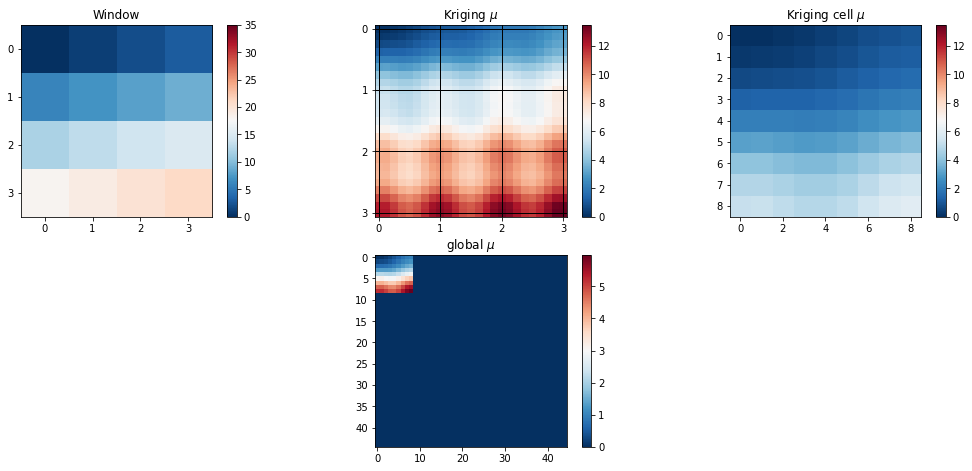

[[ 0  1  2  3]
 [ 6  7  8  9]
 [12 13 14 15]
 [18 19 20 21]]
(0, 1) (0, 1)
(0, 8) (0, 8)
(25, 25)

-----


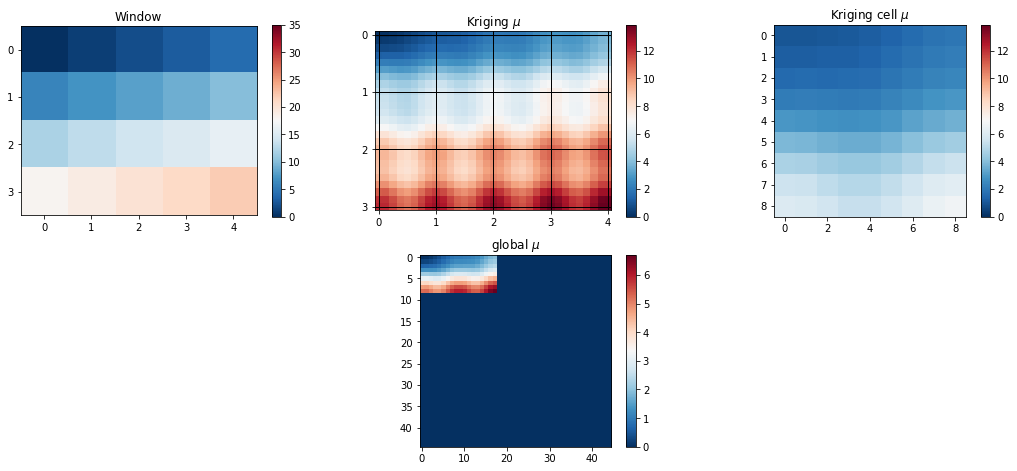

[[ 0  1  2  3  4]
 [ 6  7  8  9 10]
 [12 13 14 15 16]
 [18 19 20 21 22]]
(1, 2) (0, 1)
(0, 8) (8, 16)
(25, 33)

-----


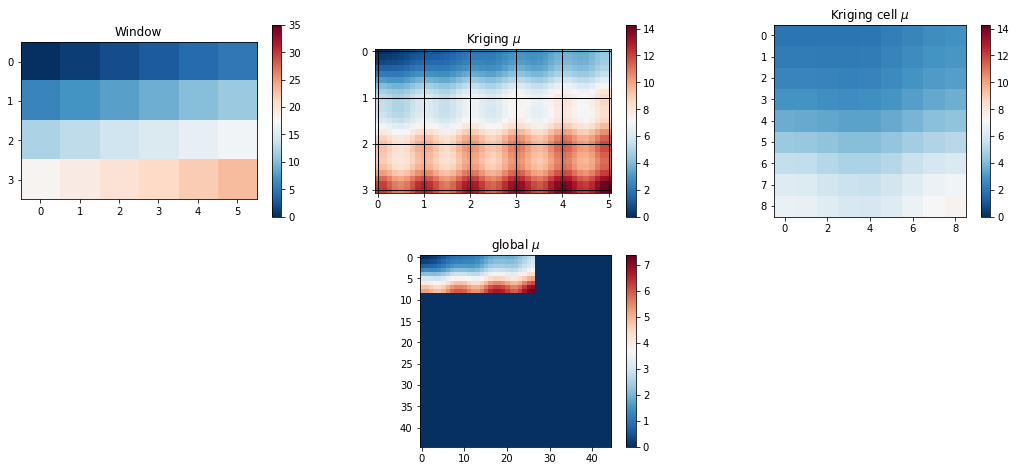

[[ 0  1  2  3  4  5]
 [ 6  7  8  9 10 11]
 [12 13 14 15 16 17]
 [18 19 20 21 22 23]]
(2, 3) (0, 1)
(0, 8) (16, 24)
(25, 41)

-----


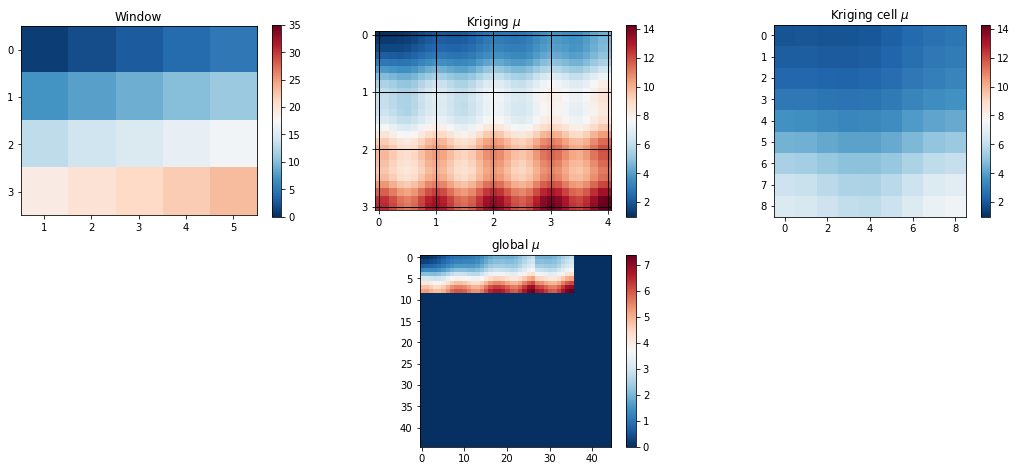

[[ 1  2  3  4  5]
 [ 7  8  9 10 11]
 [13 14 15 16 17]
 [19 20 21 22 23]]
(1, 2) (0, 1)
(0, 8) (8, 16)
(25, 33)

-----


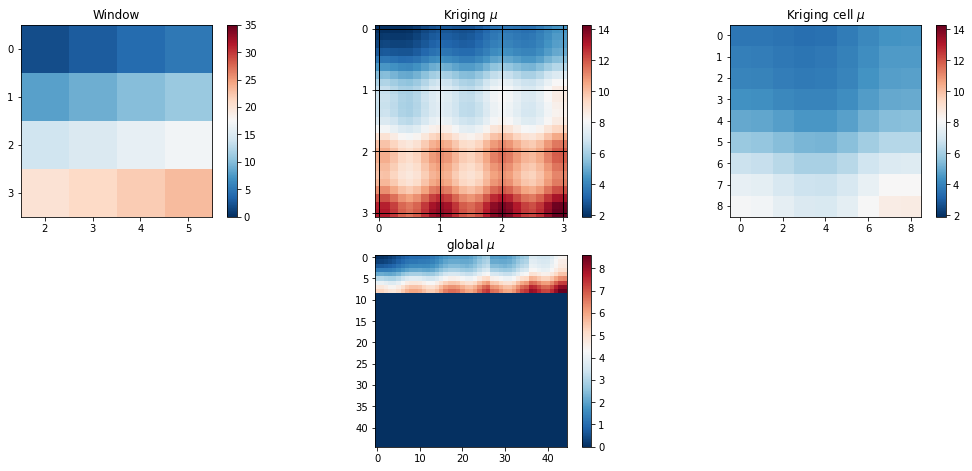

[[ 2  3  4  5]
 [ 8  9 10 11]
 [14 15 16 17]
 [20 21 22 23]]
(2, 3) (0, 1)
(0, 8) (16, 24)
(25, 25)

-----


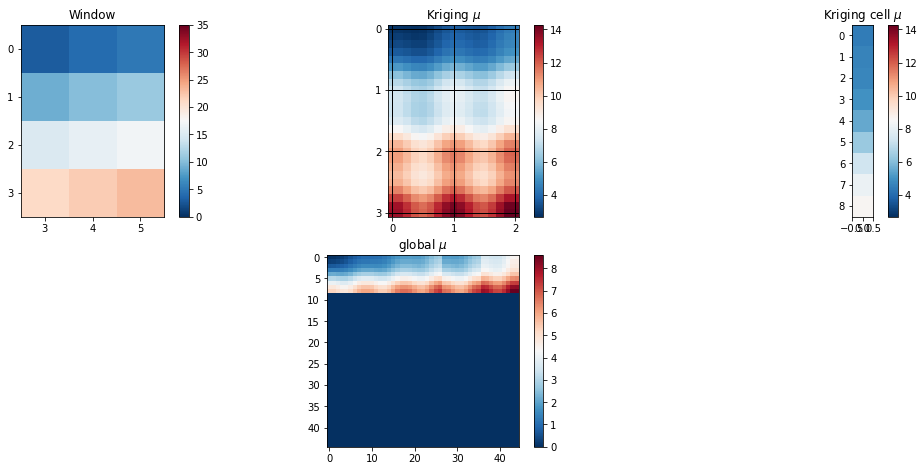

[[ 3  4  5]
 [ 9 10 11]
 [15 16 17]
 [21 22 23]]
(2, 3) (0, 1)
(0, 8) (16, 24)
(25, 17)

-----


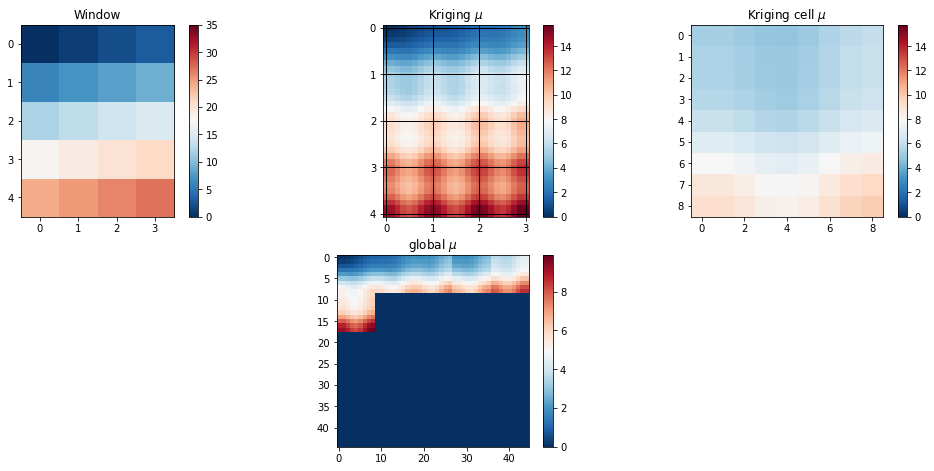

[[ 0  1  2  3]
 [ 6  7  8  9]
 [12 13 14 15]
 [18 19 20 21]
 [24 25 26 27]]
(0, 1) (1, 2)
(8, 16) (0, 8)
(33, 25)

-----


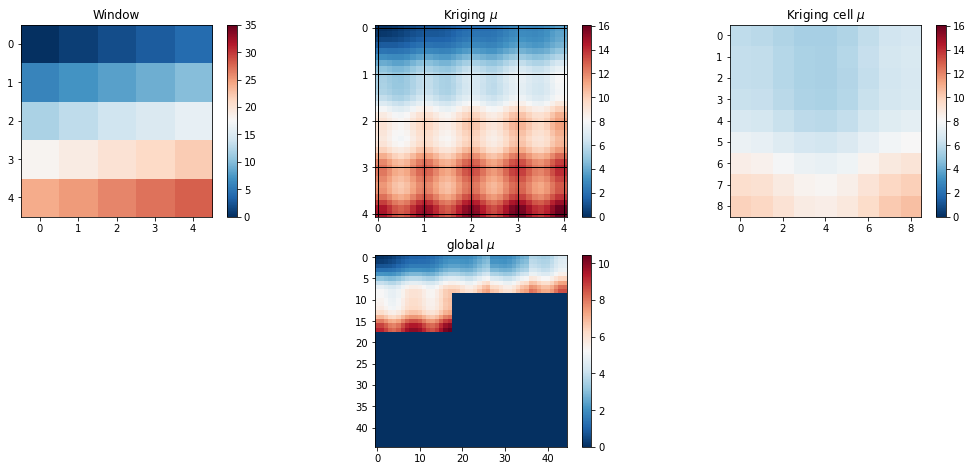

[[ 0  1  2  3  4]
 [ 6  7  8  9 10]
 [12 13 14 15 16]
 [18 19 20 21 22]
 [24 25 26 27 28]]
(1, 2) (1, 2)
(8, 16) (8, 16)
(33, 33)

-----


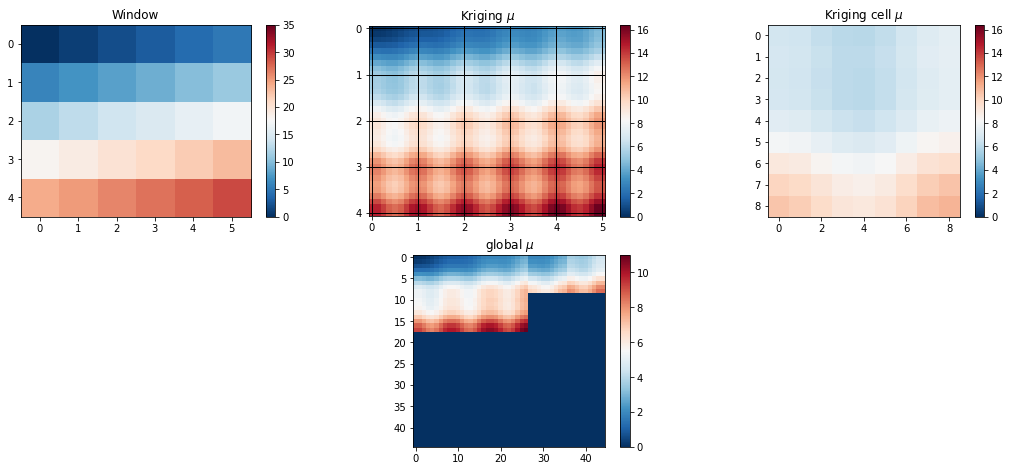

[[ 0  1  2  3  4  5]
 [ 6  7  8  9 10 11]
 [12 13 14 15 16 17]
 [18 19 20 21 22 23]
 [24 25 26 27 28 29]]
(2, 3) (1, 2)
(8, 16) (16, 24)
(33, 41)

-----


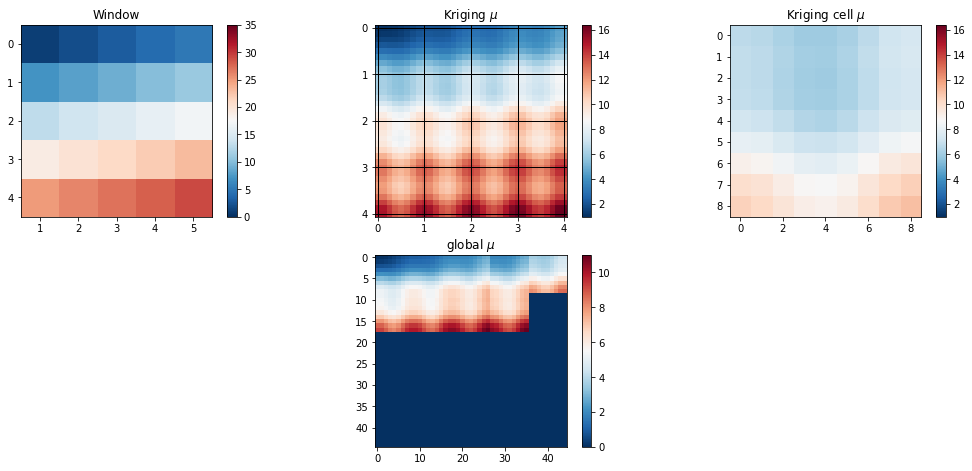

[[ 1  2  3  4  5]
 [ 7  8  9 10 11]
 [13 14 15 16 17]
 [19 20 21 22 23]
 [25 26 27 28 29]]
(1, 2) (1, 2)
(8, 16) (8, 16)
(33, 33)

-----


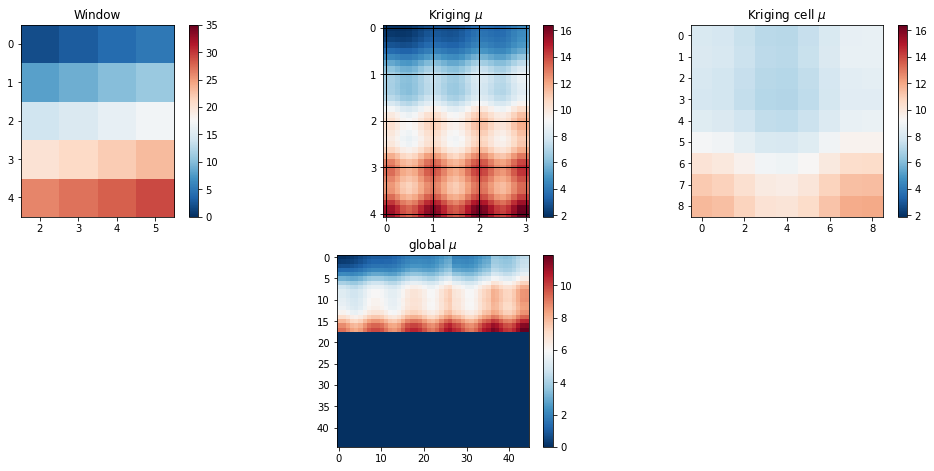

[[ 2  3  4  5]
 [ 8  9 10 11]
 [14 15 16 17]
 [20 21 22 23]
 [26 27 28 29]]
(2, 3) (1, 2)
(8, 16) (16, 24)
(33, 25)

-----


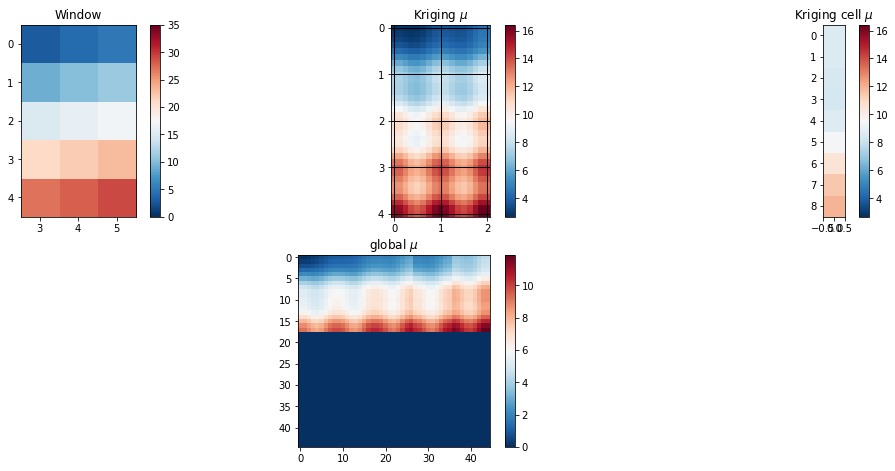

[[ 3  4  5]
 [ 9 10 11]
 [15 16 17]
 [21 22 23]
 [27 28 29]]
(2, 3) (1, 2)
(8, 16) (16, 24)
(33, 17)

-----


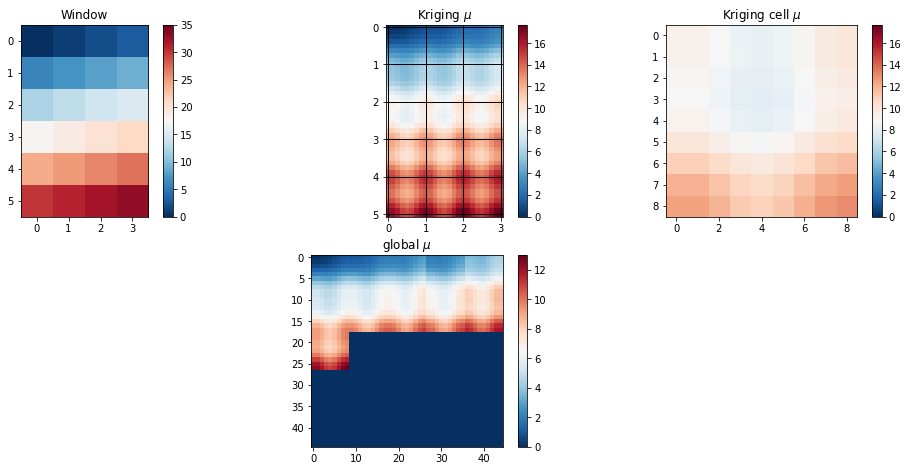

[[ 0  1  2  3]
 [ 6  7  8  9]
 [12 13 14 15]
 [18 19 20 21]
 [24 25 26 27]
 [30 31 32 33]]
(0, 1) (2, 3)
(16, 24) (0, 8)
(41, 25)

-----


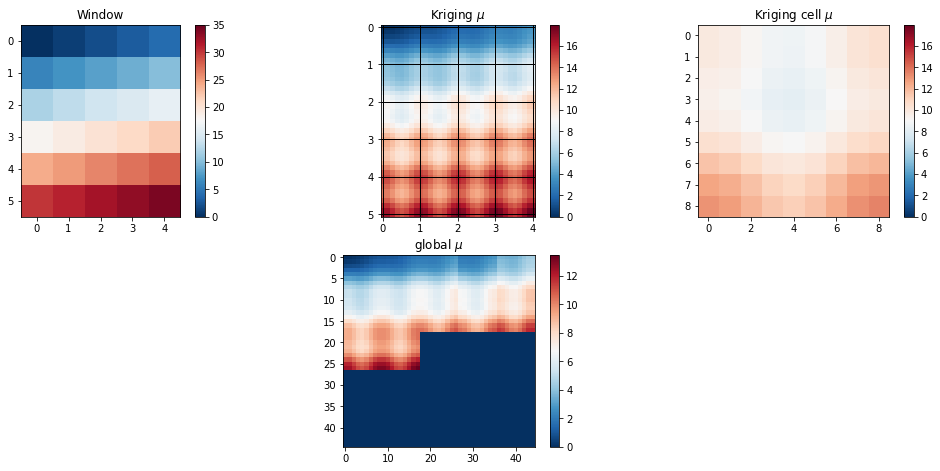

[[ 0  1  2  3  4]
 [ 6  7  8  9 10]
 [12 13 14 15 16]
 [18 19 20 21 22]
 [24 25 26 27 28]
 [30 31 32 33 34]]
(1, 2) (2, 3)
(16, 24) (8, 16)
(41, 33)

-----


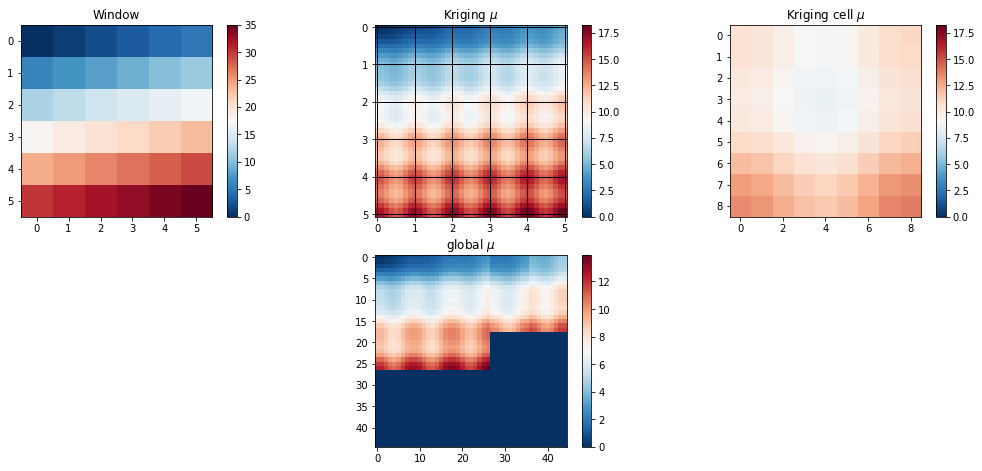

[[ 0  1  2  3  4  5]
 [ 6  7  8  9 10 11]
 [12 13 14 15 16 17]
 [18 19 20 21 22 23]
 [24 25 26 27 28 29]
 [30 31 32 33 34 35]]
(2, 3) (2, 3)
(16, 24) (16, 24)
(41, 41)

-----


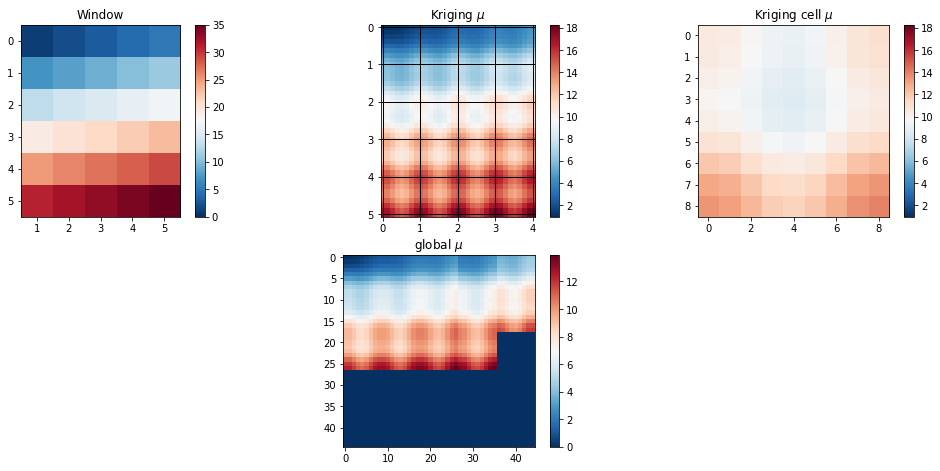

[[ 1  2  3  4  5]
 [ 7  8  9 10 11]
 [13 14 15 16 17]
 [19 20 21 22 23]
 [25 26 27 28 29]
 [31 32 33 34 35]]
(1, 2) (2, 3)
(16, 24) (8, 16)
(41, 33)

-----


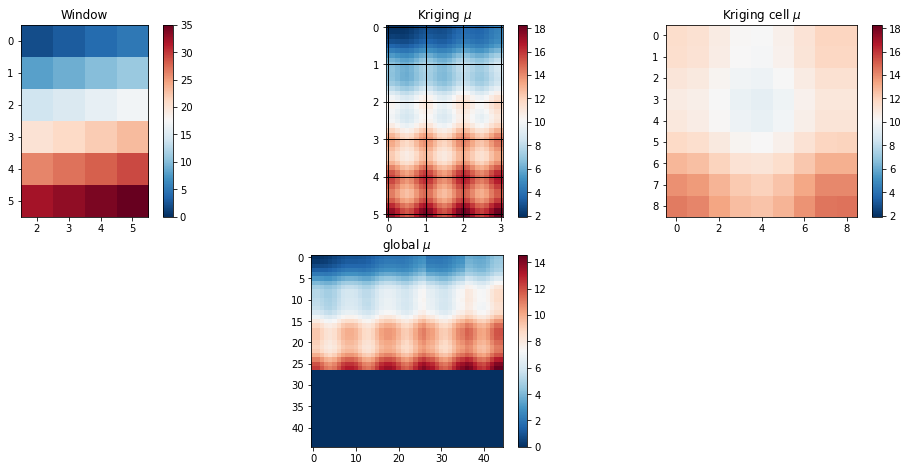

[[ 2  3  4  5]
 [ 8  9 10 11]
 [14 15 16 17]
 [20 21 22 23]
 [26 27 28 29]
 [32 33 34 35]]
(2, 3) (2, 3)
(16, 24) (16, 24)
(41, 25)

-----


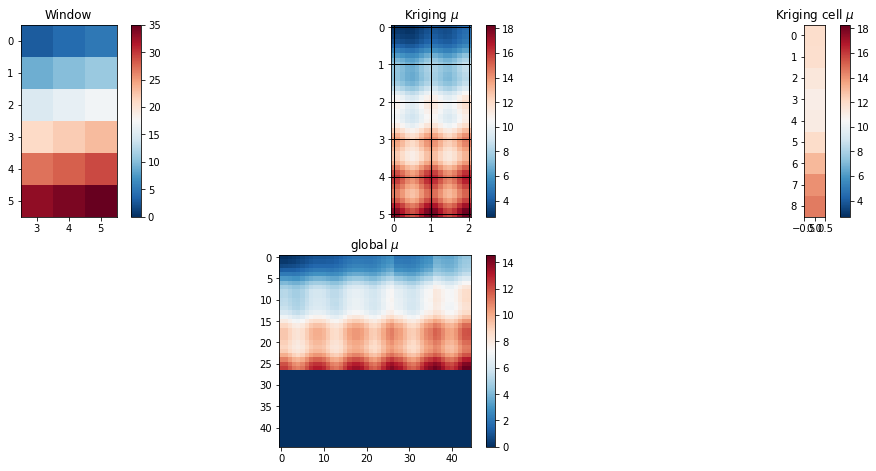

[[ 3  4  5]
 [ 9 10 11]
 [15 16 17]
 [21 22 23]
 [27 28 29]
 [33 34 35]]
(2, 3) (2, 3)
(16, 24) (16, 24)
(41, 17)

-----


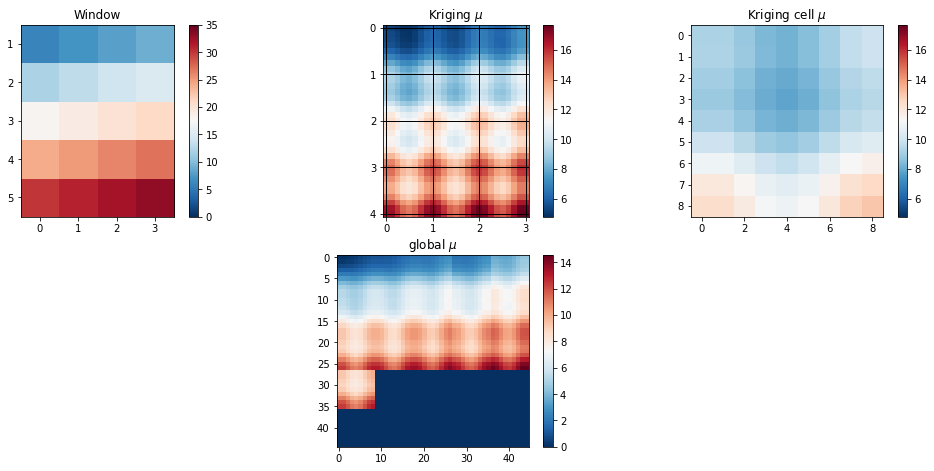

[[ 6  7  8  9]
 [12 13 14 15]
 [18 19 20 21]
 [24 25 26 27]
 [30 31 32 33]]
(0, 1) (1, 2)
(8, 16) (0, 8)
(33, 25)

-----


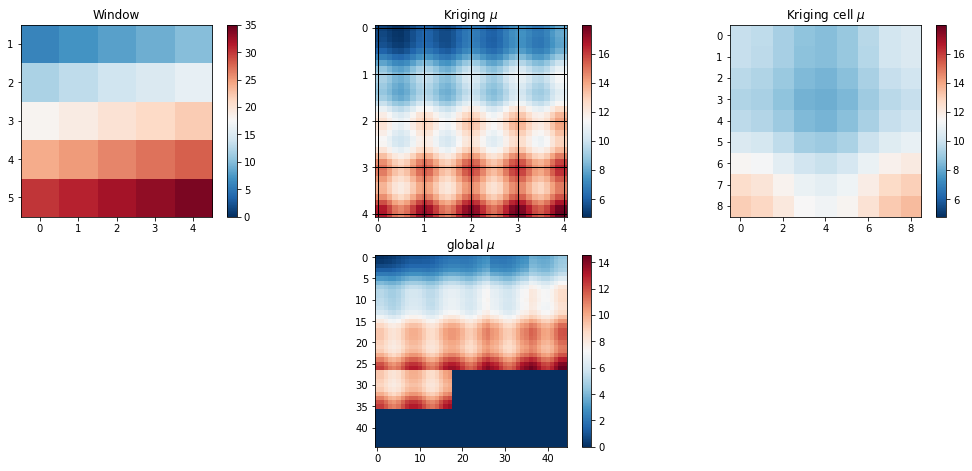

[[ 6  7  8  9 10]
 [12 13 14 15 16]
 [18 19 20 21 22]
 [24 25 26 27 28]
 [30 31 32 33 34]]
(1, 2) (1, 2)
(8, 16) (8, 16)
(33, 33)

-----


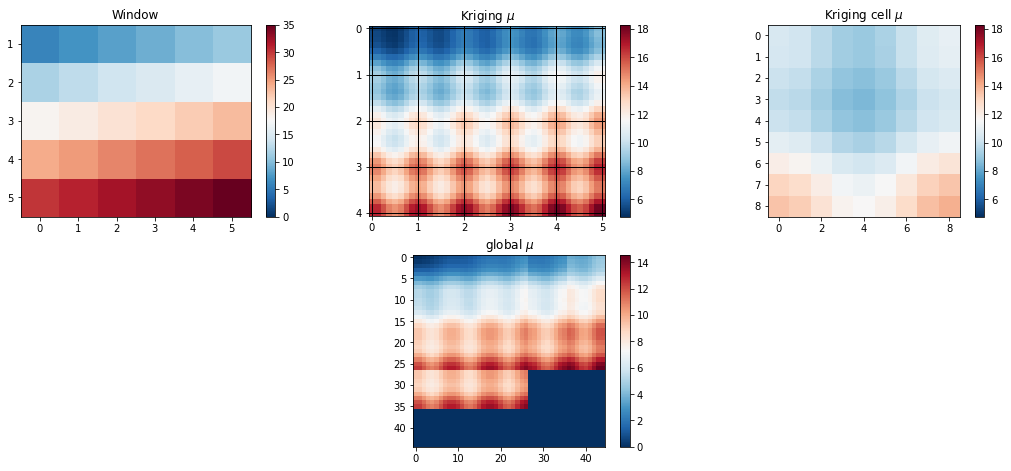

[[ 6  7  8  9 10 11]
 [12 13 14 15 16 17]
 [18 19 20 21 22 23]
 [24 25 26 27 28 29]
 [30 31 32 33 34 35]]
(2, 3) (1, 2)
(8, 16) (16, 24)
(33, 41)

-----


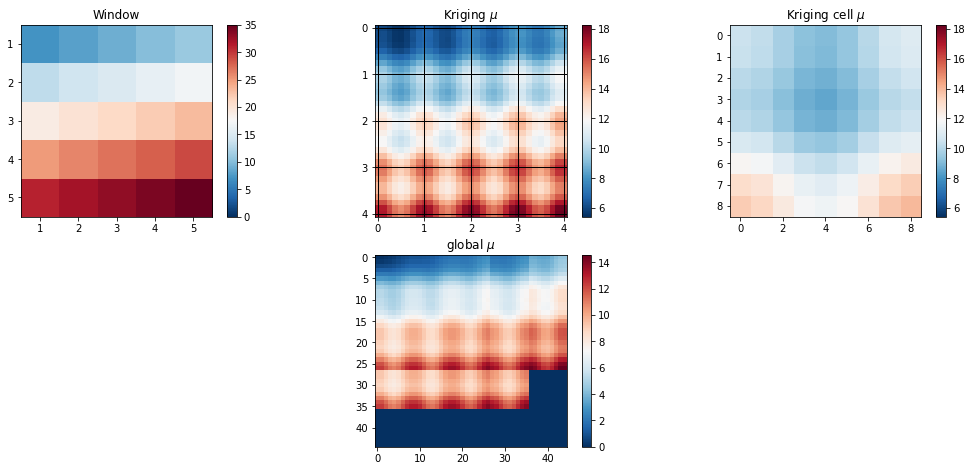

[[ 7  8  9 10 11]
 [13 14 15 16 17]
 [19 20 21 22 23]
 [25 26 27 28 29]
 [31 32 33 34 35]]
(1, 2) (1, 2)
(8, 16) (8, 16)
(33, 33)

-----


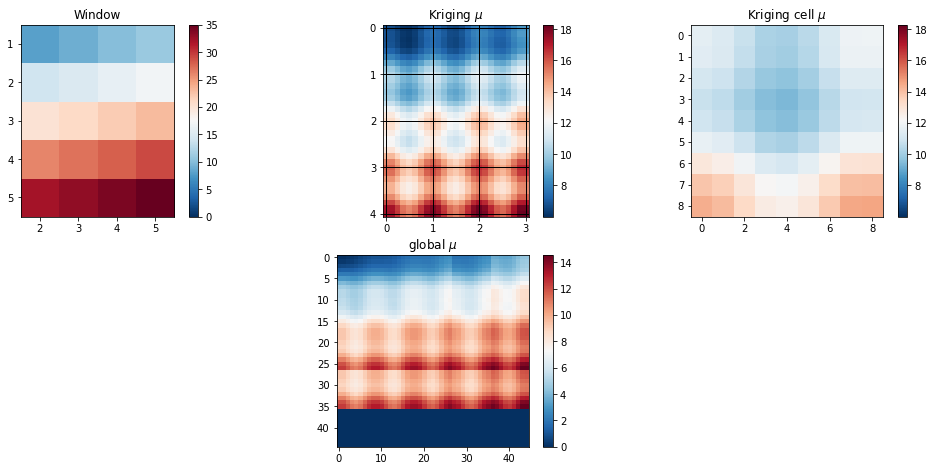

[[ 8  9 10 11]
 [14 15 16 17]
 [20 21 22 23]
 [26 27 28 29]
 [32 33 34 35]]
(2, 3) (1, 2)
(8, 16) (16, 24)
(33, 25)

-----


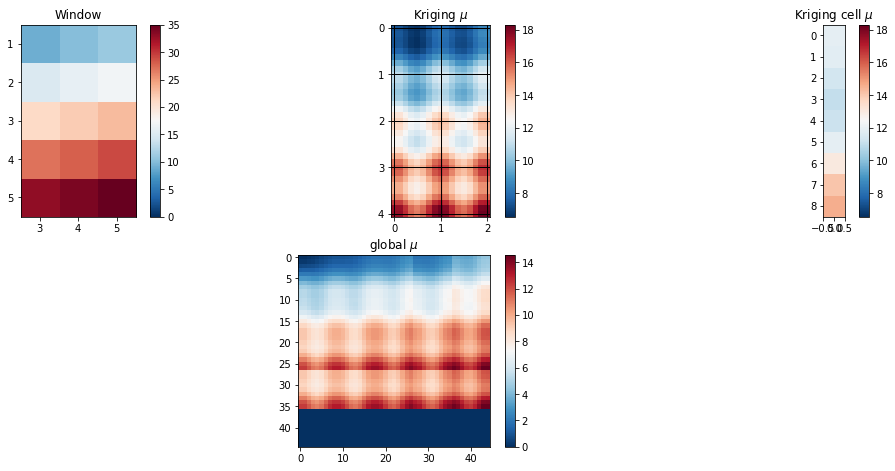

[[ 9 10 11]
 [15 16 17]
 [21 22 23]
 [27 28 29]
 [33 34 35]]
(2, 3) (1, 2)
(8, 16) (16, 24)
(33, 17)

-----


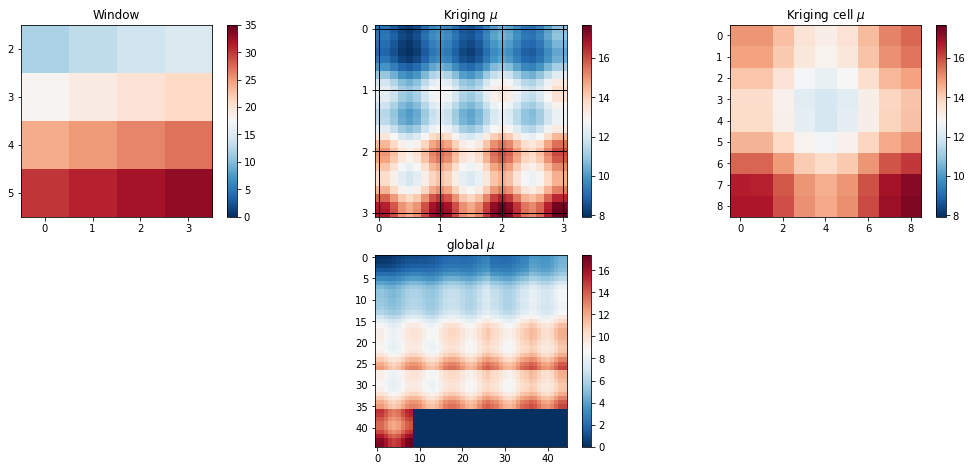

[[12 13 14 15]
 [18 19 20 21]
 [24 25 26 27]
 [30 31 32 33]]
(0, 1) (2, 3)
(16, 24) (0, 8)
(25, 25)

-----


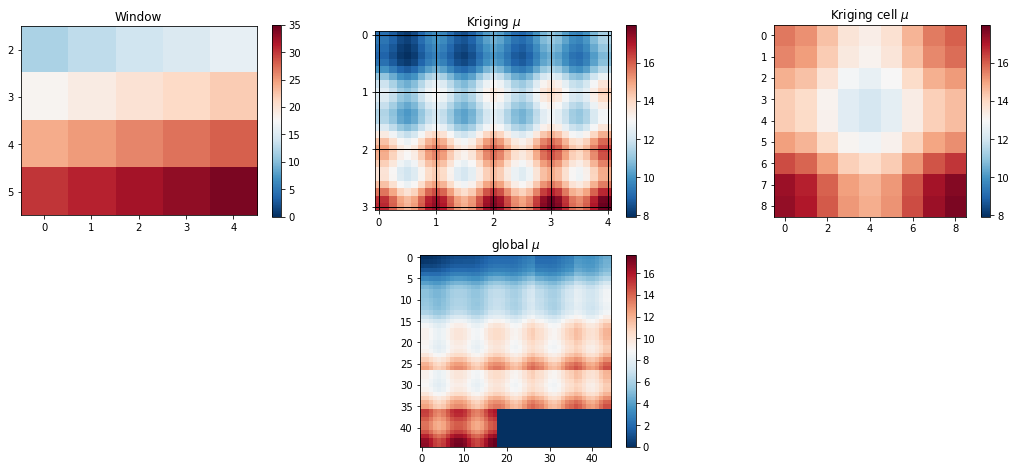

[[12 13 14 15 16]
 [18 19 20 21 22]
 [24 25 26 27 28]
 [30 31 32 33 34]]
(1, 2) (2, 3)
(16, 24) (8, 16)
(25, 33)

-----


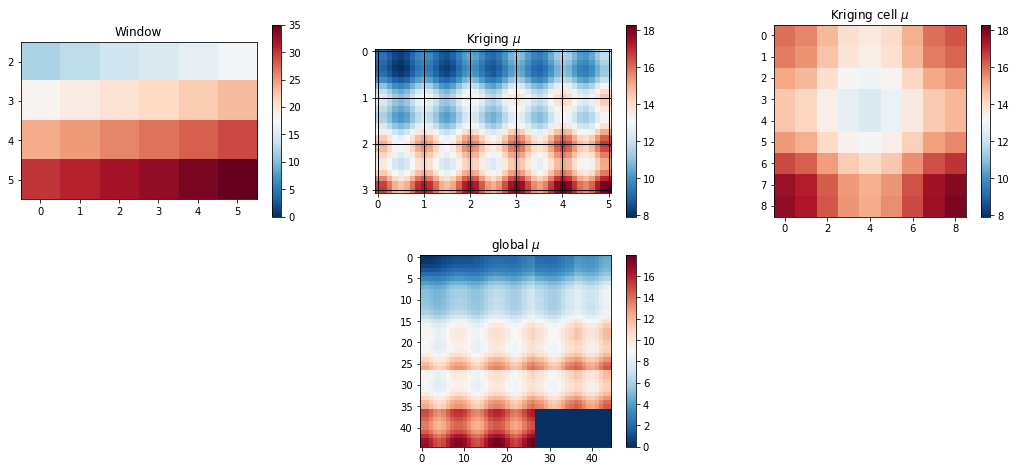

[[12 13 14 15 16 17]
 [18 19 20 21 22 23]
 [24 25 26 27 28 29]
 [30 31 32 33 34 35]]
(2, 3) (2, 3)
(16, 24) (16, 24)
(25, 41)

-----


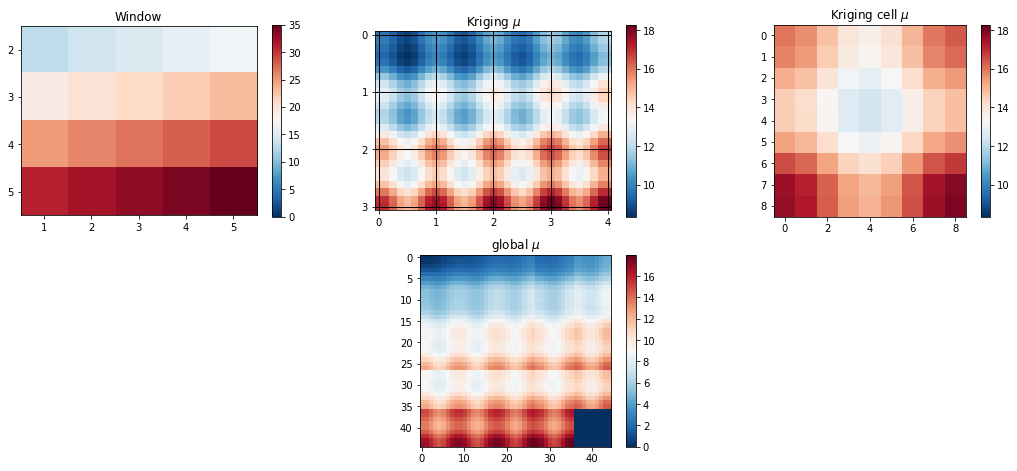

[[13 14 15 16 17]
 [19 20 21 22 23]
 [25 26 27 28 29]
 [31 32 33 34 35]]
(1, 2) (2, 3)
(16, 24) (8, 16)
(25, 33)

-----


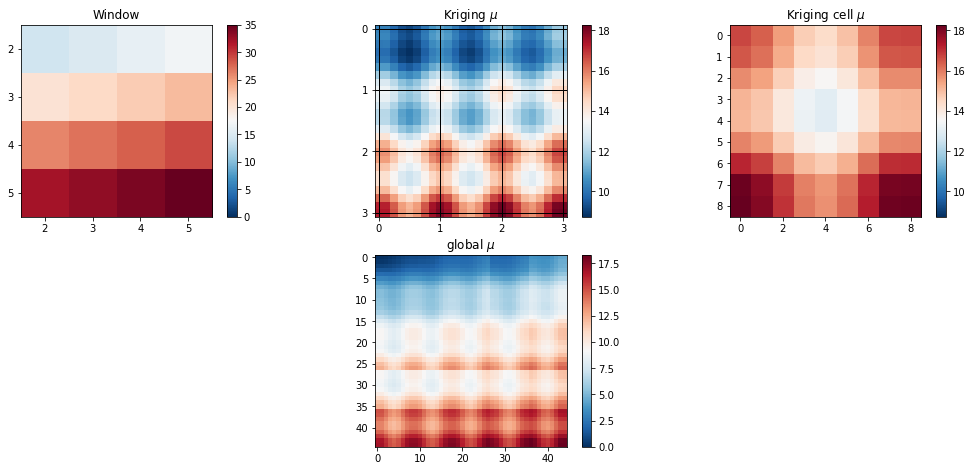

[[14 15 16 17]
 [20 21 22 23]
 [26 27 28 29]
 [32 33 34 35]]
(2, 3) (2, 3)
(16, 24) (16, 24)
(25, 25)

-----


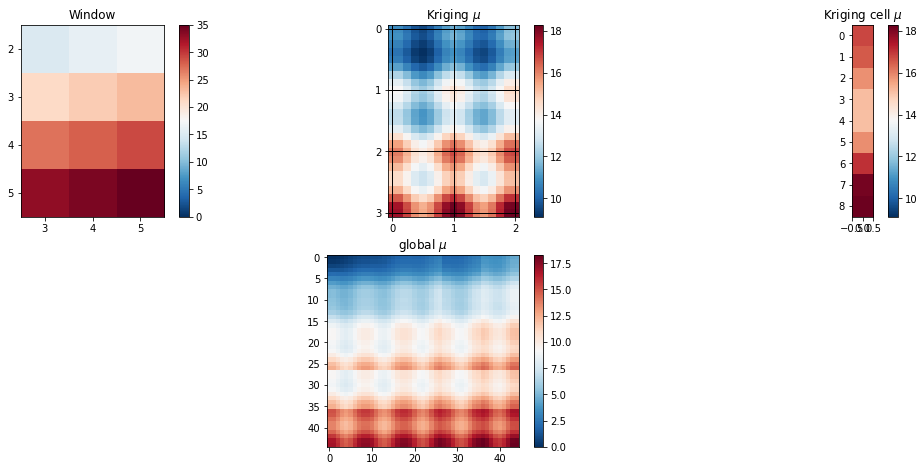

[[15 16 17]
 [21 22 23]
 [27 28 29]
 [33 34 35]]
(2, 3) (2, 3)
(16, 24) (16, 24)
(25, 17)

-----


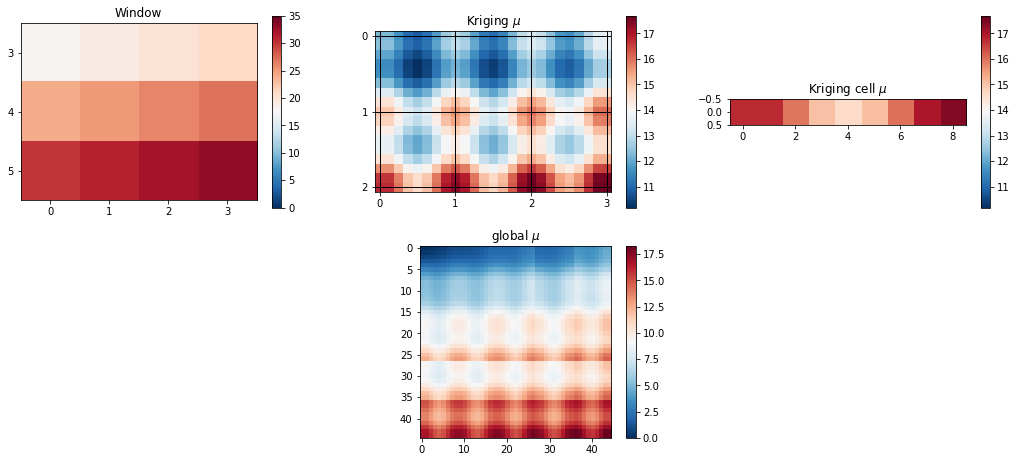

[[18 19 20 21]
 [24 25 26 27]
 [30 31 32 33]]
(0, 1) (2, 3)
(16, 24) (0, 8)
(17, 25)

-----


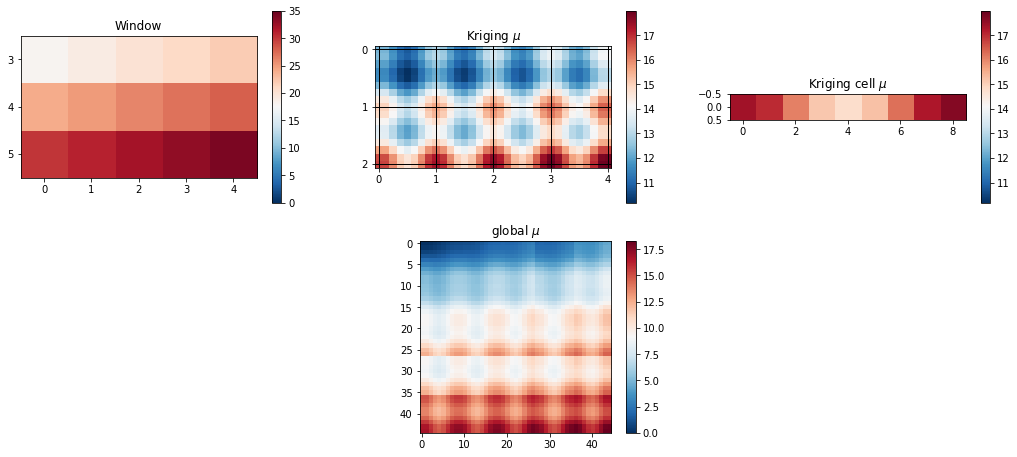

[[18 19 20 21 22]
 [24 25 26 27 28]
 [30 31 32 33 34]]
(1, 2) (2, 3)
(16, 24) (8, 16)
(17, 33)

-----


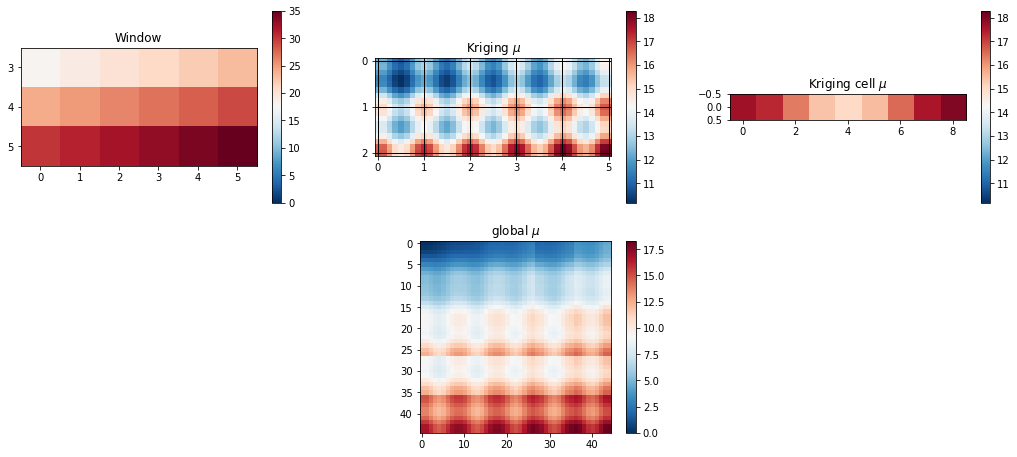

[[18 19 20 21 22 23]
 [24 25 26 27 28 29]
 [30 31 32 33 34 35]]
(2, 3) (2, 3)
(16, 24) (16, 24)
(17, 41)

-----


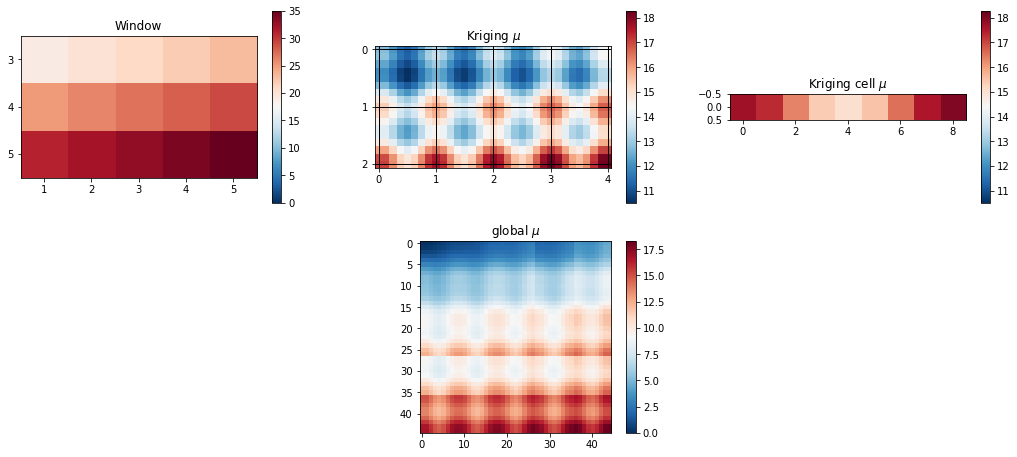

[[19 20 21 22 23]
 [25 26 27 28 29]
 [31 32 33 34 35]]
(1, 2) (2, 3)
(16, 24) (8, 16)
(17, 33)

-----


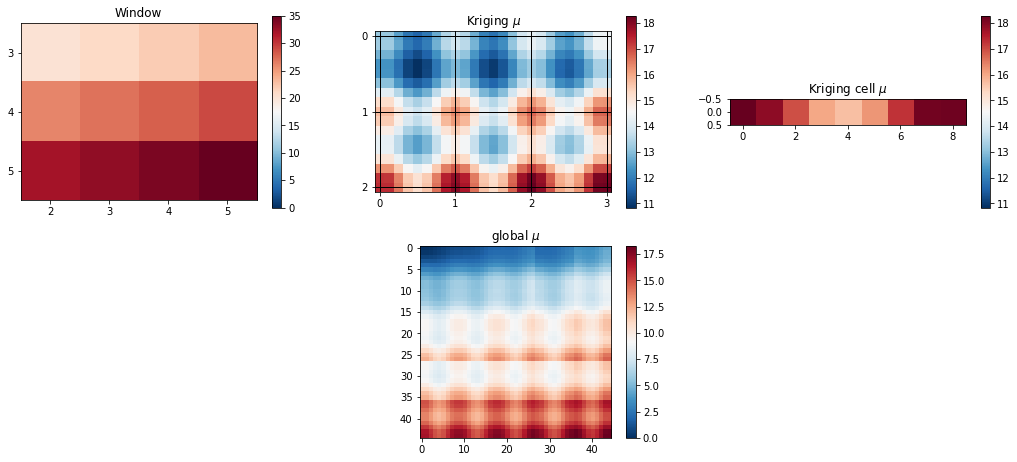

[[20 21 22 23]
 [26 27 28 29]
 [32 33 34 35]]
(2, 3) (2, 3)
(16, 24) (16, 24)
(17, 25)

-----


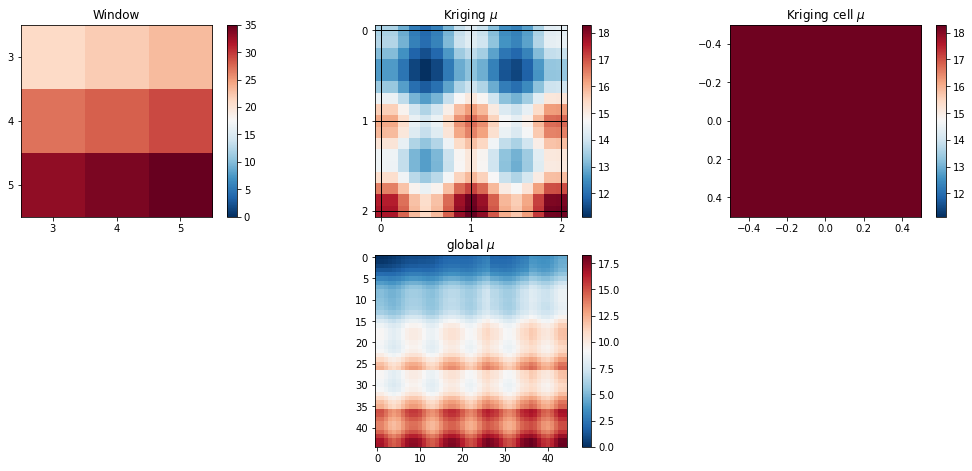

[[21 22 23]
 [27 28 29]
 [33 34 35]]
(2, 3) (2, 3)
(16, 24) (16, 24)
(17, 17)

-----


In [228]:
x = np.arange(mean_subset.shape[0])
y = np.arange(mean_subset.shape[1])

S = np.transpose(np.meshgrid(x, y), [1,2,0])

f = mean_subset
var_i = var_subset

var_p = var_i.max()
l = 0.4

influence_width = int(np.ceil(3 * l)) 
scale = 8
new_shape = (np.array(mean_subset.shape, dtype=np.int64) - 1 ) * (scale + 1)
# new_shape = np.array(mean_subset.shape, dtype=np.int64) * scale

mu1 = np.zeros(new_shape)
var1 = np.zeros(new_shape)
for i in range(mean_subset.shape[0]):
    for j in range(mean_subset.shape[1]):
        left = max(0, j - influence_width)
        right = min(mean_subset.shape[1], j + influence_width + 1)

        bottom = max(0, i - influence_width)
        top = min(mean_subset.shape[0], i + influence_width + 1)

        f_cell = f[bottom:top+1, left:right+1]
        var_i_cell = var_i[bottom:top+1, left:right+1].flatten()

        v_left =f_cell.shape[1] // 2 - 1
        v_right = f_cell.shape[1] // 2
        if j - influence_width < 0:
            v_left -= influence_width - j - 1
            v_right -= influence_width - j - 1
        if j + influence_width + 1 > mean_subset.shape[1]:
            v_left += j + influence_width + 1 - mean_subset.shape[1]
            v_right += j + influence_width + 1 - mean_subset.shape[1]

        u_bottom = f_cell.shape[0] // 2 - 1
        u_top = f_cell.shape[0] // 2
        if i - influence_width < 0:
            u_bottom -= influence_width - i - 1
            u_top -= influence_width - i - 1
        if i + influence_width + 1 > mean_subset.shape[0]:
            u_bottom += i + influence_width + 1 - mean_subset.shape[0]
            u_top += i + influence_width + 1 - mean_subset.shape[0]

        window_shape = f_cell.shape
        interploation_shape = (np.array(window_shape) - 1) * scale + 1
        f_cell = f_cell.flatten()

        S_cell = S[bottom:top+1, left:right+1].reshape((-1,2))

        s_x = np.linspace(S_cell[:,0].min(), S_cell[:,0].max(), interploation_shape[1])
        s_y = np.linspace(S_cell[:,1].min(), S_cell[:,1].max(), interploation_shape[0])

        s_interpolated = np.transpose(np.meshgrid(s_x, s_y), [1,2,0]).reshape((-1,2))

        mu_area, var_area = kriging(S_cell, f_cell, var_i_cell, s_interpolated, var_p, l)
        mu_area = mu_area.reshape(interploation_shape)
        var_area = var_area.reshape(interploation_shape)

        mu_cell = mu_area[scale * u_bottom:scale * u_top+1, scale * v_left:scale * v_right+1]
        var_cell = var_area[scale * u_bottom:scale * u_top+1, scale * v_left:scale * v_right+1]

        scale_target = scale+1

        mu1[i*scale_target:(i+1)*scale_target, j*scale_target:(j+1)*scale_target] = mu_cell
        var1[i*scale_target:(i+1)*scale_target, j*scale_target:(j+1)*scale_target] = var_cell

        # if j == mean_subset.shape[1] - 1:
        #     v_right += 1
        # if i == mean_subset.shape[0] - 1:
        #     u_top += 1
        # mu_cell = mu_area[scale * u_bottom:scale * u_top, scale * v_left:scale * v_right]
        # var_cell = var_area[scale * u_bottom:scale * u_top, scale * v_left:scale * v_right]

        # selector_y_end = (i+1)*scale if i < mean_subset.shape[0] - 1 else (i+1)*scale + 1
        # selector_x_end = (j+1)*scale if j < mean_subset.shape[1] - 1 else (j+1)*scale + 1

        # mu1[i*scale:selector_y_end, j*scale:selector_x_end] = mu_cell
        # var1[i*scale:selector_y_end, j*scale:selector_x_end] = var_cell

        fig = plt.figure(figsize=(18,12))
        grid = plt.GridSpec(3,3)
        ax1 = fig.add_subplot(grid[0,0])
        ax1.set_title('Window')
        img1 = ax1.imshow(f_cell.reshape(window_shape), cmap='RdBu_r', vmin=mean_subset.min(), vmax=mean_subset.max())
        ax1.set_xticks(np.arange(window_shape[1]))
        ax1.set_xticklabels(np.arange(left, left + window_shape[1]))
        ax1.set_yticks(np.arange(window_shape[0]))
        ax1.set_yticklabels(np.arange(bottom, bottom + window_shape[0]))
        plt.colorbar(img1, ax=ax1)

        ax2 = fig.add_subplot(grid[0,1])
        ax2.set_title(r'Kriging $\mu$')
        img2 = ax2.imshow(mu_area, cmap='RdBu_r')
        ax2.set_xticks(np.arange(0, mu_area.shape[1], scale_target-1))
        ax2.set_xticklabels(np.arange(window_shape[1]))
        ax2.set_yticks(np.arange(0, mu_area.shape[0], scale_target-1))
        ax2.set_yticklabels(np.arange(window_shape[0]))
        ax2.grid(c='k', lw=1)
        plt.colorbar(img2, ax=ax2)

        ax3 = fig.add_subplot(grid[0,2])
        ax3.set_title(r'Kriging cell $\mu$')
        img3 = ax3.imshow(mu_cell, cmap='RdBu_r', vmin=mu_area.min(), vmax=mu_area.max())
        plt.colorbar(img3, ax=ax3)

        ax4 = fig.add_subplot(grid[1,1])
        ax4.set_title(r'global $\mu$')
        img4 = ax4.imshow(mu1, cmap='RdBu_r')
        plt.colorbar(img4, ax=ax4)

        plt.show()

        print(f_cell.reshape(window_shape))
        print((v_left, v_right), (u_bottom, u_top))
        print((scale * u_bottom, scale * u_top), (scale * v_left, scale * v_right))
        print(mu_area.shape)
        print()
        print('-'*5)

    #     if j > 2:
    #         break
    # if i > 0:
    #     break

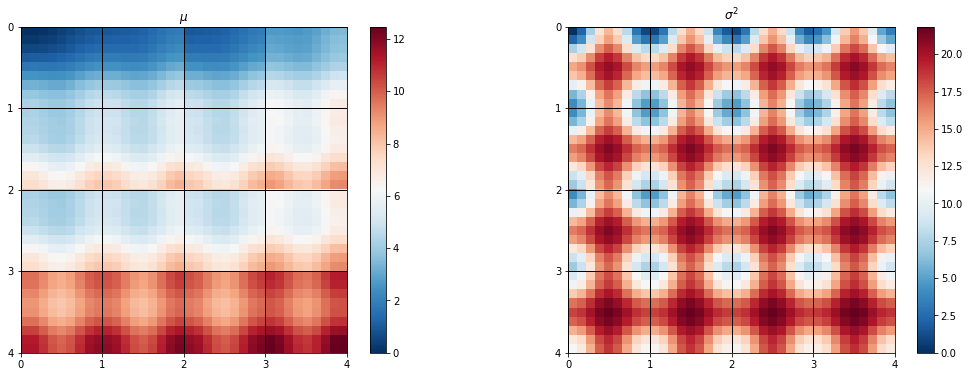

In [211]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.title(r'$\mu$')
plt.imshow(mu1, cmap='RdBu_r', interpolation='none')
plt.xticks(np.arange(0,mu1.shape[0]+1,scale+1)-0.5, x)
plt.yticks(np.arange(0,mu1.shape[1]+1,scale+1)-0.5, y)
plt.grid(c='k', lw=1)
plt.colorbar()

plt.subplot(1,2,2)
plt.title(r'$\sigma^2$')
plt.imshow(var1, cmap='RdBu_r', interpolation='none')
plt.xticks(np.arange(0,var1.shape[0]+1,scale+1)-0.5, x)
plt.yticks(np.arange(0,var1.shape[1]+1,scale+1)-0.5, y)
plt.grid(c='k', lw=1)
plt.colorbar()

plt.show()

# Subset of the Data

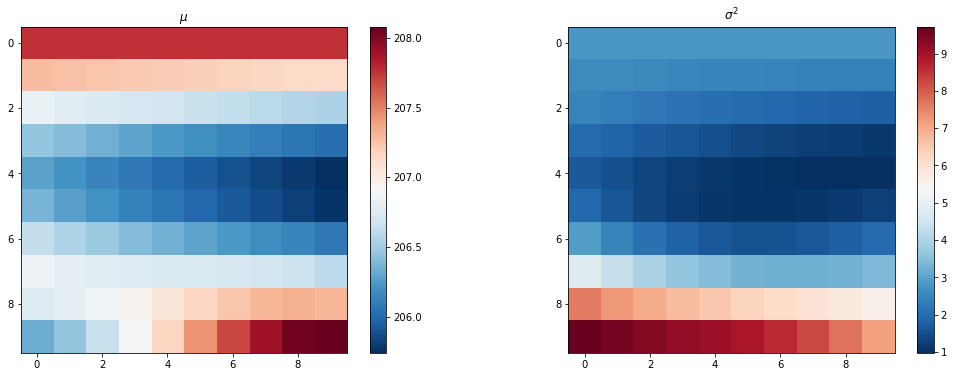

In [111]:
mean_subset = mean[:10,:10]
var_subset = var[:10,:10]

plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.title(r'$\mu$')
plt.imshow(mean_subset, cmap='RdBu_r')
plt.colorbar()

plt.subplot(1,2,2)
plt.title(r'$\sigma^2$')
plt.imshow(var_subset, cmap='RdBu_r')
plt.colorbar()

plt.show()

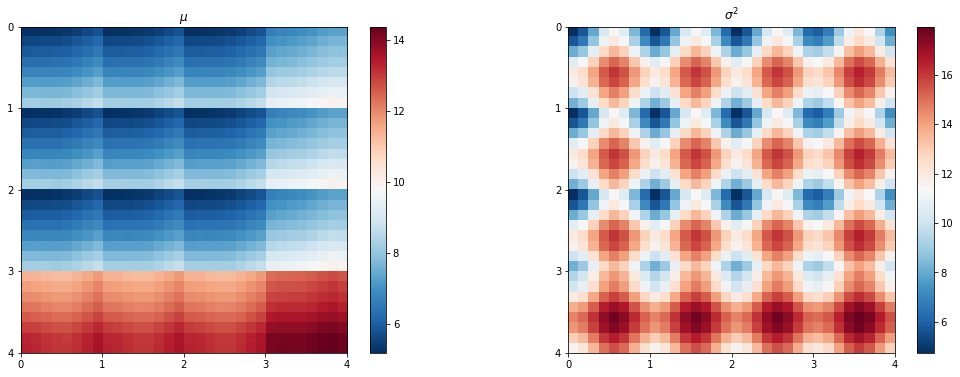

In [125]:
scale = 8
mu2, var2 = piecewise_kriging(mean_subset, var_subset, var_subset.max(), 0.5, scale)

x = np.arange(mean_subset.shape[0])
y = np.arange(mean_subset.shape[1])

plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.title(r'$\mu$')
plt.imshow(mu2, cmap='RdBu_r', interpolation='none')
plt.xticks(np.arange(0,mu2.shape[0]+1,scale)-0.5, x)
plt.yticks(np.arange(0,mu2.shape[1]+1,scale)-0.5, y)
#plt.grid(c='k', lw=2)
plt.colorbar()

plt.subplot(1,2,2)
plt.title(r'$\sigma^2$')
plt.imshow(var2, cmap='RdBu_r', interpolation='none')
plt.xticks(np.arange(0,var2.shape[0]+1,scale)-0.5, x)
plt.yticks(np.arange(0,var2.shape[1]+1,scale)-0.5, y)
#plt.grid(c='k', lw=2)
plt.colorbar()

plt.show()